In [1]:
import torch 
from torch import nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2 as cv
import os 
import glob
import random
from PIL import Image
import os
from torchvision import models
import torchvision.transforms.functional as TF
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.amp.autocast_mode import autocast
from torch.amp.grad_scaler import GradScaler
import lpips
import csv
from pytorch_msssim import ssim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CUSTOM DATASET

In [2]:
class Satellite_dataset(Dataset):
    def __init__(self, root_dir, split = "train"):
        super().__init__()
        
        self.lr_dir = os.path.join(root_dir, split, "LR")
        self.hr_dir = os.path.join(root_dir, split, "HR")
        
        self.images_files = sorted(os.listdir(self.lr_dir))
        
        self.lr_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            
        ])
        
        self.hr_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            
        ])
        
    def __len__(self):
        return len(self.images_files)
    
    def __getitem__(self, index):
        filename = self.images_files[index]
        lr = Image.open(os.path.join(self.lr_dir, filename)).convert("RGB")
        hr = Image.open(os.path.join(self.hr_dir, filename)).convert("RGB")
        
        lr = self.lr_transform(lr)
        hr = self.hr_transform(hr)
        
        return lr, hr

# DATA LOADERS

In [3]:
ROOT_DIR = r"./satellite-processed"
BATCH_SIZE = 16
NUM_WORKERS = 3



train_dataset = Satellite_dataset(ROOT_DIR, "train")
val_dataset = Satellite_dataset(ROOT_DIR, "val")
test_dataset = Satellite_dataset(ROOT_DIR, "test")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)

lr, hr = next(iter(train_loader))
print(len(train_loader))
print("lr.shape : ", lr.shape)
print("hr.shape : ", hr.shape)

11506
lr.shape :  torch.Size([16, 3, 32, 32])
hr.shape :  torch.Size([16, 3, 128, 128])


# HELPER FUNCTIONS

In [4]:
def vgg_preprocess(x):
    # [-1,1] → [0,1]
    x = (x + 1) / 2
    mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1,3,1,1)
    return (x - mean) / std

# SAMPLES VISUALISATION

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7254902..0.7254902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.5137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.41960788].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..0.43529415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4980392..0.52156866].


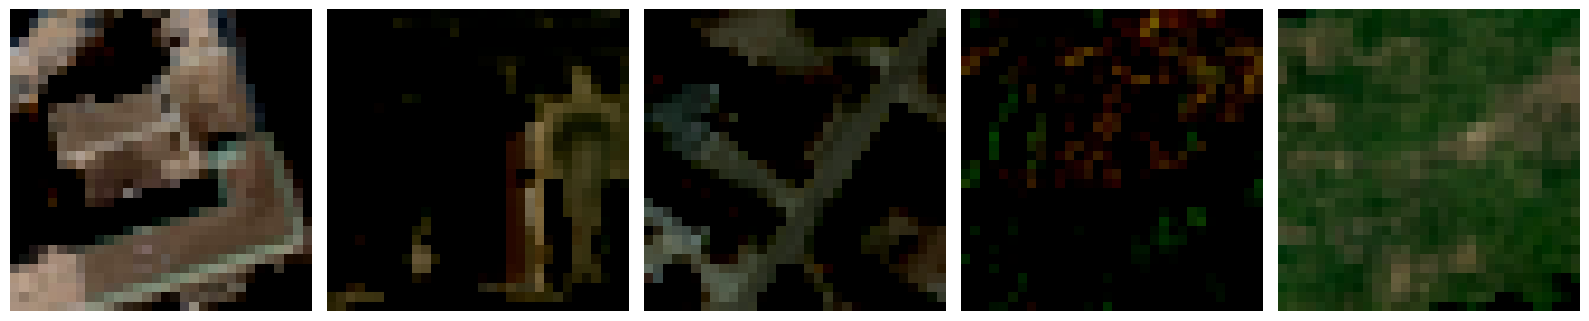

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.827451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64705884..0.62352943].


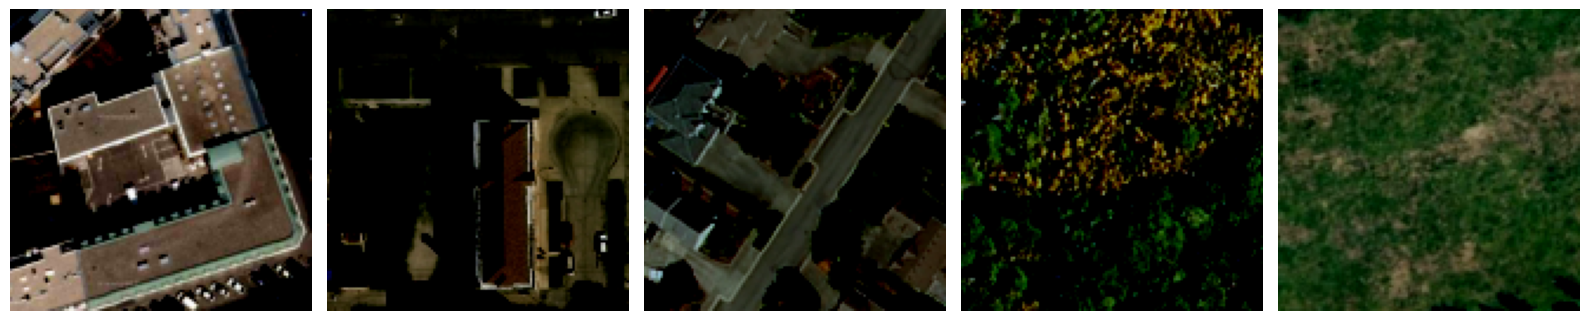

In [5]:
lr, hr = next(iter(train_loader))

# PLOTING LOWER RES IMAGES
plt.figure(figsize=(16, 5))
rows, cols = 1, 5
for i in range(rows * cols):
    img = lr[i]
    plt.subplot(rows, cols, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
plt.tight_layout()
plt.show()


# PLOTING HIGHIER RES IMAGES
plt.figure(figsize=(16, 5))
rows, cols = 1, 5
for i in range(rows * cols):
    img = hr[i]
    plt.subplot(rows, cols, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
plt.tight_layout()
plt.show()

# GENERATOR NET

In [6]:
GROWTH_RATE = 16
RESIDUAL_SCALE = 0.2
N_DENSE_LAYERS = 4

class Dense_layer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels, growth_rate, 3, 1, 1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        out = self.relu(self.conv(x))
        # dim=1 concatination au niveau des channels
        return torch.cat([x, out], dim=1)

class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels, n_dense_layers=4, growth_rate=32, residual_scale=0.2):
        super().__init__()
        
        self.residual_scale = residual_scale
        self.rdb = nn.Sequential(*[Dense_layer(in_channels + i * growth_rate, growth_rate) for i in range(n_dense_layers)])
        self.conv = nn.Conv2d(in_channels + n_dense_layers * growth_rate, in_channels, 3, 1, 1)
        
    def forward(self, x):
        out = self.rdb(x)
        return self.conv(out) * self.residual_scale + x
    
class RRDB(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.rdb1 = ResidualDenseBlock(channels)
        self.rdb2 = ResidualDenseBlock(channels)
        self.rdb3 = ResidualDenseBlock(channels)

    def forward(self, x):
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        return x + 0.2 * out


class GENERATOR(nn.Module):
    def __init__(self, in_channels, num_features, num_blocks):
        super().__init__()
        self.first_conv = nn.Conv2d(in_channels, num_features, 9, 1, 9//2)
        
        self.RRDB = nn.Sequential(
            *[RRDB(num_features) for i in range(num_blocks)]
        )
        
        self.tail_res = nn.Conv2d(num_features, num_features, 3, 1, 1)
        
        self.upsample = nn.Sequential(
            nn.Conv2d(num_features, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(num_features, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(num_features, 3, 9, 1, 9//2),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.first_conv(x)
        out = self.RRDB(x)
        out = self.tail_res(out) + x
        out = self.upsample(out)
        return out

# DISCRIMINATOR NET

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.LeakyReLU(0.2)
        )
        layers = []
        in_ch = 64
        for _ in range(3):
            layers.append(nn.Sequential(
                nn.Conv2d(in_ch, in_ch, 3, 2, 1),
                nn.LeakyReLU(0.2),
                nn.Conv2d(in_ch, in_ch*2, 3, 1, 1),
                nn.LeakyReLU(0.2)
            ))
            in_ch *= 2
        self.blocks = nn.Sequential(*layers)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(1024),
            nn.Dropout(0.3),
            nn.LeakyReLU(0.2),
            nn.LazyLinear(1)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.blocks(x)
        x = self.fc(x)
        return x

# VGG FOR CONTENT LOSS

In [9]:
class VGGFeatureExtractor(nn.Module):
    def __init__(self, device='cuda', feature_layer=34):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()
        for p in vgg.parameters():
            p.requires_grad = False
        self.features = nn.Sequential(*list(vgg.children())[:feature_layer+1]).to(device)

    def forward(self, x):
        return self.features(x)

# Stage 2: GAN TRAINING

In [ ]:
# ================= CONFIG =================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

STAGE1_DIR = "./checkpoint-ESRGAN/stage-1"
STAGE2_DIR = "./checkpoint-ESRGAN/stage-2"
os.makedirs(STAGE2_DIR, exist_ok=True)

LR_G = 1e-4
LR_D = 5e-5

LAMBDA_ADV = 5e-3
LAMBDA_VGG = 1.0
LAMBDA_PIXEL = 1e-2

MILESTONES = [50_000, 100_000, 200_000, 300_000]
GAMMA = 0.5

CSV_PATH = os.path.join(STAGE2_DIR, "metrics.csv")
CKPT_LATEST = os.path.join(STAGE2_DIR, "latest.pth")
CKPT_BEST = os.path.join(STAGE2_DIR, "best_lpips.pth")

# ================= MODELS =================
gen = GENERATOR(3, 64, 18).to(DEVICE)
disc = Discriminator().to(DEVICE)
vgg = VGGFeatureExtractor(device=DEVICE).eval().to(DEVICE)

lpips_fn = lpips.LPIPS(net="alex").eval().to(DEVICE)

gen.load_state_dict(torch.load(os.path.join(STAGE1_DIR, "best_gen.pth"), map_location=DEVICE))
print("Loaded Stage-1 Generator")

# ================= OPTIM =================
opt_G = optim.Adam(gen.parameters(), lr=LR_G, betas=(0.9, 0.999))
opt_D = optim.Adam(disc.parameters(), lr=LR_D, betas=(0.9, 0.999))

sched_G = optim.lr_scheduler.MultiStepLR(
    opt_G, milestones=MILESTONES, gamma=GAMMA
)

scaler = GradScaler()

bce = nn.BCEWithLogitsLoss()
l1 = nn.L1Loss()

# ================= HELPERS =================
def vgg_preprocess(x):
    x = (x + 1) / 2
    mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1,3,1,1)
    return (x - mean) / std

def calc_psnr(sr, hr):
    mse = torch.mean((sr - hr) ** 2)
    return 20 * torch.log10(2.0 / torch.sqrt(mse))

# ================= CHECKPOINT =================
def save_ckpt(path, epoch, iteration, best_lpips):
    torch.save({
        "epoch": epoch,
        "iter": iteration,
        "gen": gen.state_dict(),
        "disc": disc.state_dict(),
        "opt_G": opt_G.state_dict(),
        "opt_D": opt_D.state_dict(),
        "sched_G": sched_G.state_dict(),
        "best_lpips": best_lpips
    }, path)

def load_ckpt():
    if not os.path.exists(CKPT_LATEST):
        return 0, 0, float("inf")
    ckpt = torch.load(CKPT_LATEST, map_location=DEVICE)
    gen.load_state_dict(ckpt["gen"])
    disc.load_state_dict(ckpt["disc"])
    opt_G.load_state_dict(ckpt["opt_G"])
    opt_D.load_state_dict(ckpt["opt_D"])
    sched_G.load_state_dict(ckpt["sched_G"])
    print("✔ Resumed Stage-2")
    return ckpt["epoch"] + 1, ckpt["iter"], ckpt["best_lpips"]

# ================= CSV =================
if not os.path.exists(CSV_PATH):
    with open(CSV_PATH, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch","iter",
            "train_g","train_d","train_vgg",
            "train_psnr","train_ssim",
            "val_g","val_d","val_vgg",
            "val_psnr","val_ssim","val_lpips",
            "lr"
        ])

# ================= TRAIN STEP =================
def train_step(lr, hr):
    # ---- D ----
    opt_D.zero_grad(set_to_none=True)
    with autocast(device_type=DEVICE):
        fake = gen(lr)
        real_pred = disc(hr)
        fake_pred = disc(fake.detach())

        d_real = bce(real_pred - fake_pred.mean(), torch.ones_like(real_pred))
        d_fake = bce(fake_pred - real_pred.mean(), torch.zeros_like(fake_pred))
        loss_D = (d_real + d_fake) / 2

    scaler.scale(loss_D).backward()
    scaler.step(opt_D)

    # ---- G ----
    opt_G.zero_grad(set_to_none=True)
    with autocast(device_type=DEVICE):
        fake_pred = disc(fake)
        real_pred = disc(hr).detach()

        loss_G_adv = (
            bce(fake_pred - real_pred.mean(), torch.ones_like(fake_pred)) +
            bce(real_pred - fake_pred.mean(), torch.zeros_like(real_pred))
        ) / 2

        vgg_fake = vgg(vgg_preprocess(fake))
        vgg_real = vgg(vgg_preprocess(hr)).detach()
        loss_VGG = l1(vgg_fake, vgg_real)

        loss_pixel = l1(fake, hr)

        loss_G = (
            LAMBDA_ADV * loss_G_adv +
            LAMBDA_VGG * loss_VGG +        # SAVE BEST MODEL
        if val_psnr > best_psnr:
            best_psnr = val_psnr
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "best_psnr": best_psnr
            }
            if scheduler is not None:
                checkpoint["scheduler"] = scheduler.state_dict()

            torch.save(checkpoint, best_model_path)

            print(f" New BEST model saved at epoch {epoch+1} with PSNR = {best_psnr:.2f}")
        
        last_checkpoint = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "best_psnr": best_psnr
        }

        if scheduler is not None:
            last_checkpoint["scheduler"] = scheduler.state_dict()

        torch.save(last_checkpoint, last_model_path)

            LAMBDA_PIXEL * loss_pixel
        )

    scaler.scale(loss_G).backward()
    scaler.step(opt_G)
    scaler.update()

    psnr = calc_psnr(fake.float(), hr.float()).item()

    ssim_val = ssim(
        ((fake + 1) / 2).float(),
        ((hr + 1) / 2).float(),
        data_range=1.0
    ).item()


    return loss_G.item(), loss_D.item(), loss_VGG.item(), psnr, ssim_val

# ================= TRAIN LOOP =================
def train_stage2(epochs):
    start_epoch, iteration, best_lpips = load_ckpt()

    for epoch in range(start_epoch, epochs):
        gen.train()
        disc.train()

        tg=td=tv=tp=ts=0
        for lr, hr in tqdm(train_loader, desc=f"Epoch {epoch}"):
            lr, hr = lr.to(DEVICE), hr.to(DEVICE)

            g,d,v,p,s = train_step(lr, hr)
            sched_G.step()
            iteration += 1

            tg+=g; td+=d; tv+=v; tp+=p; ts+=s

        tg/=len(train_loader); td/=len(train_loader)
        tv/=len(train_loader); tp/=len(train_loader); ts/=len(train_loader)

        # ---- VALIDATION ----
        gen.eval(); disc.eval()
        vg=vd=vv=vp=vs=vl=0

        with torch.no_grad():
            for lr, hr in val_loader:
                lr, hr = lr.to(DEVICE), hr.to(DEVICE)
                sr = gen(lr)

                vd += bce(disc(sr), torch.zeros_like(disc(sr))).item()
                vg += bce(disc(sr), torch.ones_like(disc(sr))).item()

                vf = vgg(vgg_preprocess(sr))
                vr = vgg(vgg_preprocess(hr))
                vv += l1(vf, vr).item()

                vp += calc_psnr(sr, hr).item()
                vs += ssim((sr+1)/2, (hr+1)/2, data_range=1.0).item()
                vl += lpips_fn(sr.float(), hr.float()).mean().item()


        n = len(val_loader)
        vg/=n; vd/=n; vv/=n; vp/=n; vs/=n; vl/=n

        save_ckpt(CKPT_LATEST, epoch, iteration, best_lpips)
        if vl < best_lpips:
            best_lpips = vl
            save_ckpt(CKPT_BEST, epoch, iteration, best_lpips)
            print("New BEST LPIPS model saved")

        with open(CSV_PATH,"a",newline="") as f:
            csv.writer(f).writerow([
                epoch, iteration,
                tg,td,tv,tp,ts,
                vg,vd,vv,vp,vs,vl,
                opt_G.param_groups[0]["lr"]
            ])

        print(f"Epoch {epoch} | Val LPIPS {vl:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/adnane/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adnane/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/adnane/miniconda3/envs/torch/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Loaded Stage-1 Generator


/home/adnane/miniconda3/envs/torch/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path,

In [11]:
# ================= RUN =================
train_stage2(30)

/tmp/ipykernel_8904/3919762450.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_LATEST, map_location=DEVICE)


✔ Resumed Stage-2


Epoch 29: 100%|██████████| 11506/11506 [58:19<00:00,  3.29it/s] 


New BEST LPIPS model saved
Epoch 29 | Val LPIPS 0.0998
